In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np
import seaborn as sns
import hist

In [2]:
import functools
import operator

In [3]:
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from utils import *
from setting import setting

logger.setLevel(logging.DEBUG)

import yaml
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)
config = {}
with open("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16_old.yml") as f:
    config = yaml.safe_load(f)

outfilepath = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/ttoutfile"
#==================================================set plot color==================================================
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:
#bkg_array,signal_array,data_array,sumWeight = extractCutedBranch(config,args.year,args.cat)
year = '2018';cat = 'resolved'
invarbs = ['mass2l2jet'] if cat == 'resolved' else ['mass2lj']
hist = GetHisto(year,cat,invarb=invarbs).hist
#hist = GetHisto(args.year,args.cat).hist
#logger.debug(f'keys in hist = {hist[args.cat].keys()}')
logger.info(f'Get Hist done')

[DEBUG] - [utils.py:#164] - access DY_pt50To100/resolved/SR/2lep/all/mass2l2jet 


[INFO] get histo from /cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/hist_2018.root


[DEBUG] - [utils.py:#164] - access DY_pt50To100/resolved/CR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt100To250/resolved/SR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt100To250/resolved/CR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt250To400/resolved/SR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt250To400/resolved/CR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt400To650/resolved/SR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt400To650/resolved/CR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt650ToInf/resolved/SR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access DY_pt650ToInf/resolved/CR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access TTTo2L2Nu/resolved/SR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access TTTo2L2Nu/resolved/CR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - access WWTo2L2Nu/resolved/SR/2lep/all/mass2l2jet 
[DEBUG] - [utils.py:#164] - a

In [5]:
def Conditional_norm_2Dhisto(h,nbins):
    temp_h = h
    for bin in range(0,nbins):
        nevents = temp_h[bin,:].values().sum()
        if(nevents==0.0): continue
        #temp_h.view(flow=False).value[bin,:]  = np.nan_to_num(temp_h.view(flow=False).value[bin,:],0.0)
        temp_h.view().value[bin,:] = temp_h.view().value[bin,:]/nevents
    return temp_h

#evaluate alpha value by given massZZ histogram as type of boost_histogram from alpha histo and create a new alpha array
def getAlphaArray(alpha_histo,massZZ_histo):
    nbins = massZZ_histo.axes[0].size
    nbins_alpha = alpha_histo.axes[0].size
    logger.debug(f'nbins for this massZZ histo = {nbins}')
    alpha_array = np.zeros(nbins)
    for i in range(nbins):
        logger.debug(f'i for loop nbins = {i}')
        massZZ = massZZ_histo.axes[0].centers[i]
        logger.debug(f'massZZ = {massZZ}')
        bin = alpha_histo.axes[0].index(int(massZZ))
        #if the range of massZZ is out of alpha histo range, set the bin to the last bin of alpha histo
        if bin>=nbins_alpha:
            bin = nbins_alpha-1
            logger.warning(f'bin is out of alpha histo range, set bin to the last bin of alpha histo. last bin value of alpha histo = {alpha_histo.axes[0].centers[bin]}')
            alpha_array[i] = alpha_histo[bin].value
        else:
            logger.debug(f'bin = {bin}')
            logger.debug(f'alpha_histo.axes[0].centers[bin] = {alpha_histo.axes[0].centers[bin]}')
            logger.debug(f'alpha_histo[bin].value = {alpha_histo[bin].value}')
            alpha_array[i] = alpha_histo[bin].value
        #alpha_array[i] = alpha_histo[int(massZZ)].value
    return alpha_array

In [6]:
massZZ_bins = setting().massZZ_bins['resolved' if cat =='resolved' else 'merged']
#massZZ_bins = setting().massZZ_bins()
regions = ['CR','SR']
#reg = 'SR'
print(f'massZZ bins = {massZZ_bins}')

if(cat=='resolved'):
    massZZ='mass2l2jet'; kd = 'KD_Zjj'; case= 'resolved'; casename = 'resolved'
elif(cat=='merged_tag'):
    massZZ='mass2lj'; kd = 'KD_ZJ'; case='merged'; casename = 'merged_tag'
extra_str = 'rebin_2d_raw'

#Alph_path = f'/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile/AlphaRaio{args.year}_{case}.root'
#Alph_array = uproot.lazy([f"{Alph_path}:alphatree"])

Alph_path = f'/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile/AlphaHistoFromROOTProduction_{year}.root'
Alpha_file = uproot.open(Alph_path)

nbins, xmin, xmax = config['bininfo'][kd][0], config['bininfo'][kd][1], config['bininfo'][kd][2]

massZZ bins = Variable(array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1300., 1400.,
       1500., 1600., 2000., 2400., 3000., 3500.]))


In [7]:
reg = 'SR'; cats = '2lep'
h_ttbar = hist[cat][f'TTTo2L2Nu_{reg}_{cats}_all_{massZZ}_{extra_str}']+hist[cat][f'tZq_{reg}_{cats}_all_{massZZ}_{extra_str}']

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f12c0dcadf0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f12c25610a0>, text=[])

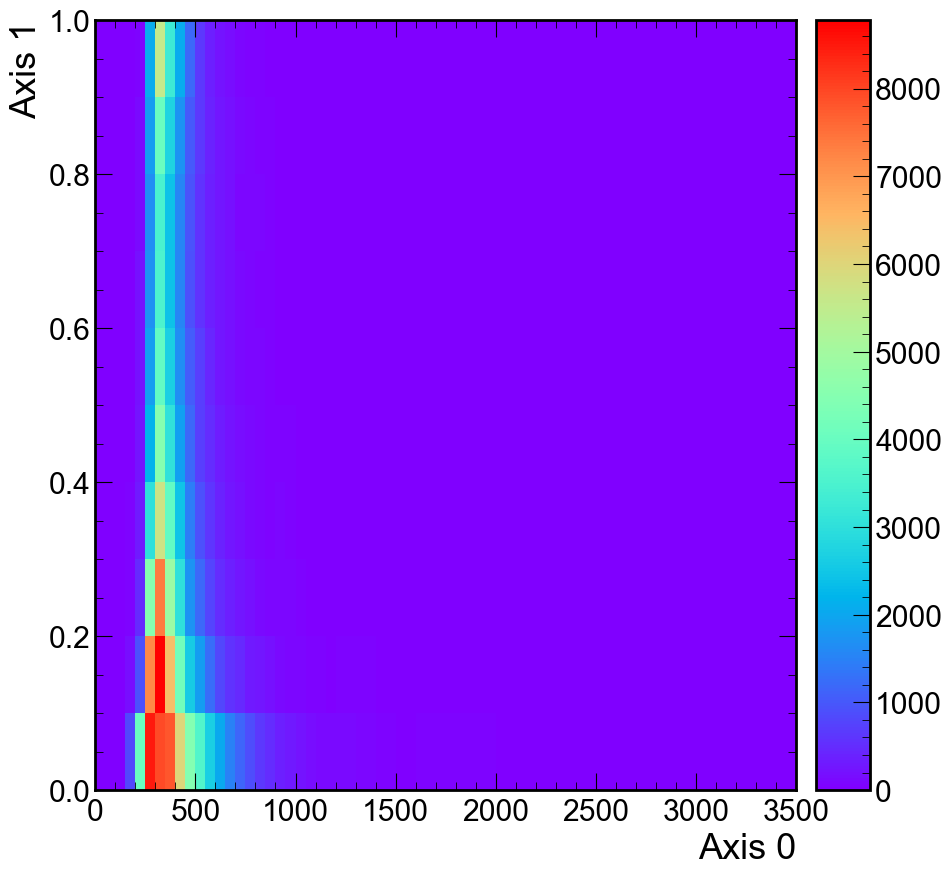

In [8]:
fig, ax = plt.subplots()
h_ttbar.plot2d(cmap='rainbow')
#mesh = ax.pcolormesh(*h_ttbar.axes.edges.T,h_ttbar.values().T,cmap='rainbow')
#fig.colorbar(mesh)


In [9]:
xbins = massZZ_bins.size
TTbar_hist = Conditional_norm_2Dhisto(h_ttbar,xbins)

In [10]:
print(massZZ_bins.size)
print(len(h_ttbar.axes[0]))

32
32


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f12c2031b80>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f12c2018fa0>, text=[])

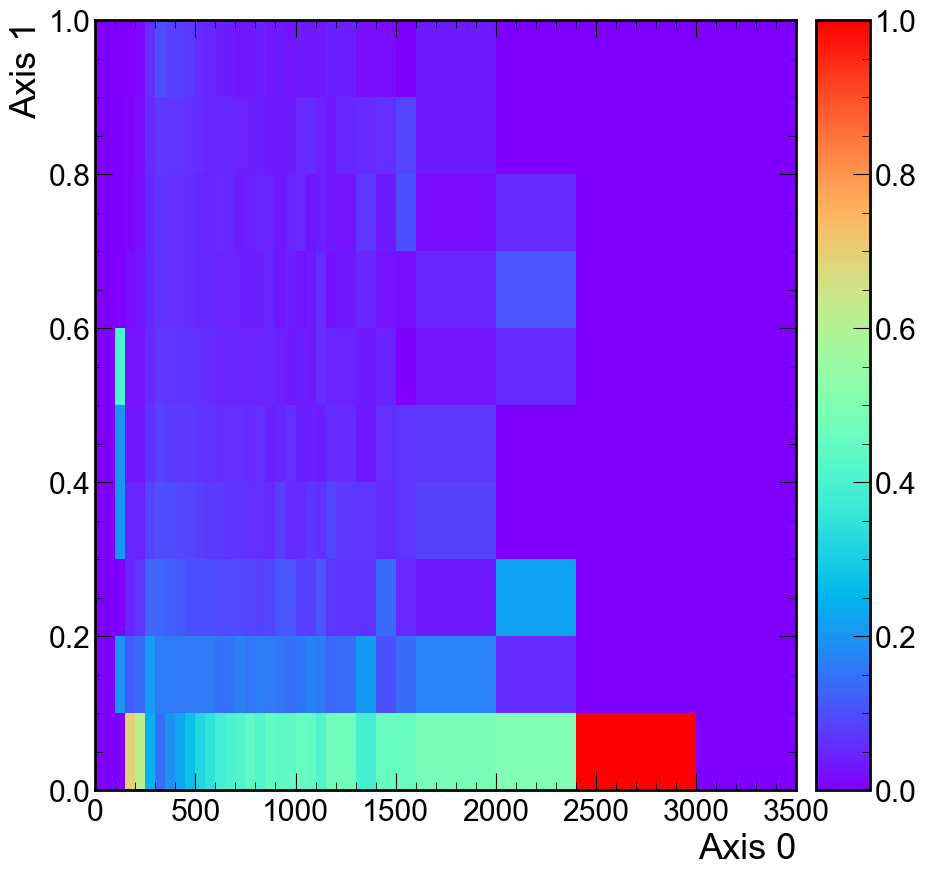

In [11]:
TTbar_hist.plot2d(cmap='rainbow')

In [14]:
print(h_ttbar.axes)
h_ttbar[28,:].values()

(Variable(array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1300., 1400.,
       1500., 1600., 2000., 2400., 3000., 3500.]), label='Axis 0'), Regular(10, 0, 1, label='Axis 1'))


array([0.48192771, 0.1686747 , 0.03614458, 0.08433735, 0.07228916,
       0.02409639, 0.04819277, 0.01204819, 0.03614458, 0.03614458])

In [130]:
len(h_ttbar.axes[0])
nevents = h_ttbar[29,:].values().sum()
normalized_y_values = h_ttbar[29,:].values()/nevents
print(normalized_y_values)
#h_ttbar.view().value[2,:] = normalized_y_values

[ 0.23949463  0.10537413  0.          0.          0.5118787   0.
  0.12111164  0.          0.          0.         -0.11808489  0.
 -0.10704843  0.0016284   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.12180502  0.
  0.12054773 -0.11716837  0.          0.          0.          0.
  0.          0.          0.          0.12046143  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [83]:
print(h_ttbar.view().value[2,:])
print(h_ttbar[2,:].values())

[0.         0.         0.         0.         0.         0.
 0.         0.18688051 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.20275871 0.         0.         0.21044168 0.         0.
 0.         0.         0.         0.         0.19875236 0.20116674
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.18688051 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.20275871 0.         0.         0.21044168 0.         0.
 0.         0.         0.         0.         0.19875236 0.20116674
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.  

In [ ]:
def Conditional_norm_2Dhisto(h,nbins):
    temp_h = h
    for bin in range(0,nbins):
        nevents = temp_h[bin,:].values(flow=False).sum()
        if(nevents==0.0): continue
        #temp_h.view(flow=False).value[bin,:]  = np.nan_to_num(temp_h.view(flow=False).value[bin,:],0.0)
        temp_h.view(flow=False).value[bin,:] = temp_h.view(flow=False).value[bin,:]/nevents
    return temp_h

In [51]:
# Get the axis along which you want to normalize (y-axis)
y_axis = h_ttbar.axes[1]

# Iterate over each x-axis bin and normalize the y-axis values
for x_bin in h_ttbar.axes[0]:
    x_bin_index = h_ttbar.axes[0].index(x_bin)
    y_values = h_ttbar.values()[x_bin_index]
    
    # Normalize the y-values to unity (sum of y-values becomes 1)
    normalized_y_values = y_values / np.sum(y_values)
    
    # Update the histogram with the normalized values
    h_ttbar.values()[x_bin_index] = normalized_y_values

IndexError: index 32 is out of bounds for axis 0 with size 32

In [59]:
# Get the x-axis and y-axis bin edges
x_bin_edges = h_ttbar.axes[0].edges
y_bin_edges = h_ttbar.axes[1].edges

# Iterate over each x-axis bin
for x_bin in range(len(x_bin_edges) - 1):
    # Get the y-axis values for the current x-axis bin
    y_values = h_ttbar.values()[x_bin, :]

    # Calculate the sum of y-axis values
    sum_y = np.sum(y_values)

    # Normalize the y-axis values by dividing by the sum
    normalized_y_values = y_values / sum_y

    # Fill the normalized histogram with the normalized values
    h_ttbar[x_bin, :] = normalized_y_values

/tmp/ipykernel_25737/1517797204.py:14: RuntimeWarning: invalid value encountered in true_divide
  normalized_y_values = y_values / sum_y


ValueError: Needs matching ndarray or n+1 dim array

1e-32